# Lesson 1/2 Code Along

Replicating https://github.com/fastai/fastai/blob/e1df9c167918f1b349e1cb43517666773fc70c22/courses/dl1/lesson1.ipynb

In [1]:
# put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importing the libraries we need:

In [2]:
# This file contains all main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import * # <-- this is an important one
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/dogscats/"
sz = 224

If not already: `wget http://files.fast.ai/data/dogscats.zip`

## A first look at cat pictures

In [5]:
!ls {PATH}

models	results  sample  subm  subm.gz	test1  tmp  train  valid


In [6]:
!ls {PATH}valid

cats  dogs


In [7]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

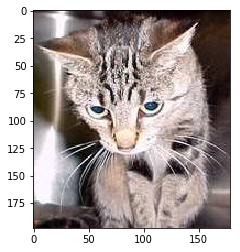

In [8]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

This is what the raw data looks like:

In [9]:
img.shape

(198, 179, 3)

In [10]:
img[:4,:4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

In [11]:
# number of cat training images
!ls {PATH}train/cats | wc -l

11500


## First model: Quick Start

Using a pretrained ResNet34 model.

For Computer Vision, ResNet34 is usually what you want to start with. It's fast and accurate. Start with 1 epoch, and if that's not enough to produce a good answer, run more.

In [12]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [13]:
ARCH = resnet34
# The data sits in a fastai data object
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(ARCH, sz))
# The learner is a fastai concept similar to a model - exists inside learn
learn = ConvLearner.pretrained(ARCH, data, precompute=True)
# learn is fitted to the data
learn.fit(0.01, 3)

# [epoch   trn_loss   val_loss   accuracy]

100%|██████████| 32/32 [00:15<00:00,  2.09it/s]


A Jupyter Widget

[ 0.       0.05566  0.02928  0.99072]                          
[ 1.       0.04038  0.0298   0.98926]                          
[ 2.       0.04081  0.02708  0.99219]                          



## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples each of: 

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5)

In [14]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [15]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [16]:
# this gives predictions for the validation set. Predictions are in log scale (PyTorch)
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [17]:
# Taking a look at the first 10 predictions:
log_preds[:10]

array([[ -0.01118,  -4.49942],
       [ -0.     , -13.96021],
       [ -0.00003, -10.3062 ],
       [ -0.00014,  -8.88253],
       [ -0.00001, -11.42328],
       [ -0.00087,  -7.04625],
       [ -0.00001, -11.11036],
       [ -0.00001, -11.80172],
       [ -0.00116,  -6.75855],
       [ -0.     , -12.40986]], dtype=float32)

In [18]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # P(dog)

In [27]:
# functions for visualizing images:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)


def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Correctly classified


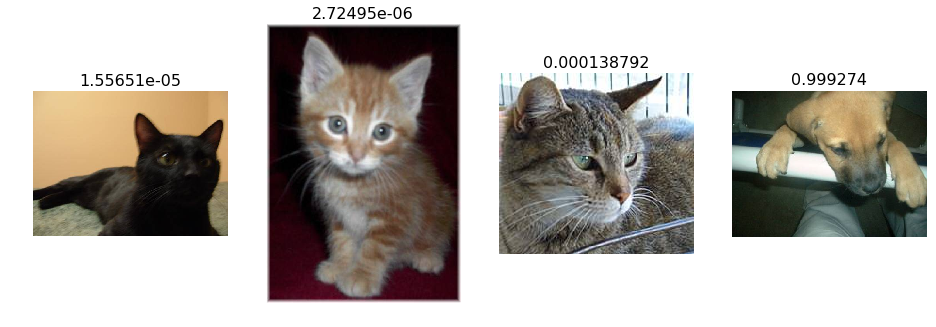

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly Classified


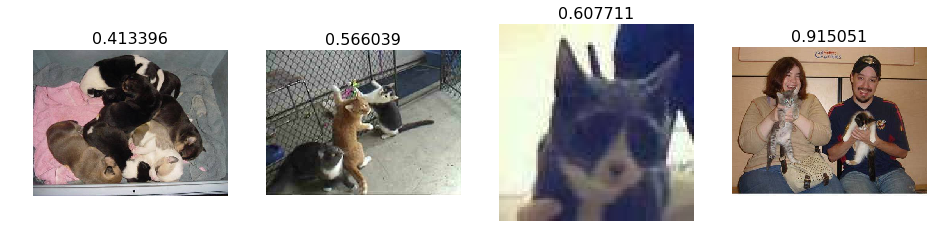

In [49]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

Most correct cats


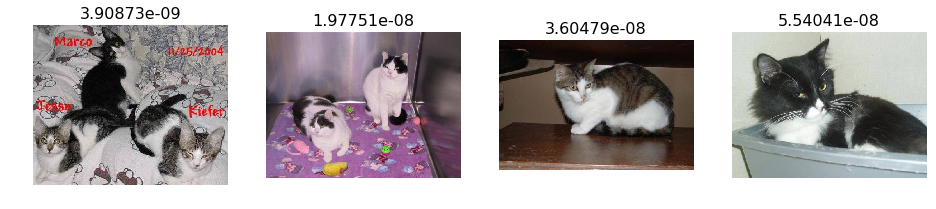

In [49]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


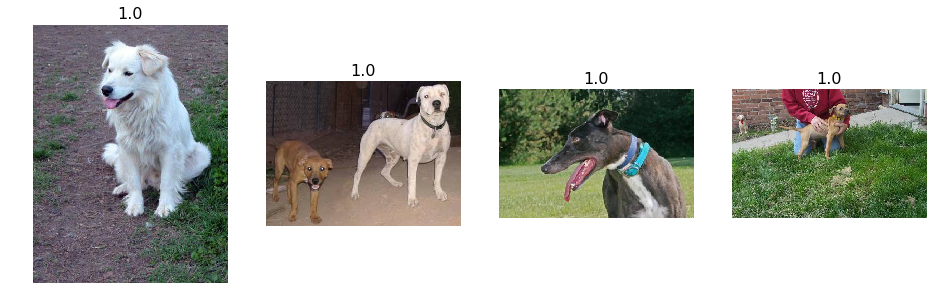

In [53]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


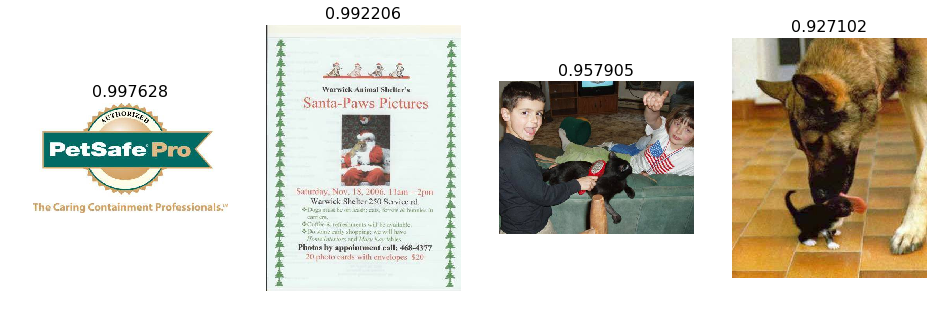

In [50]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


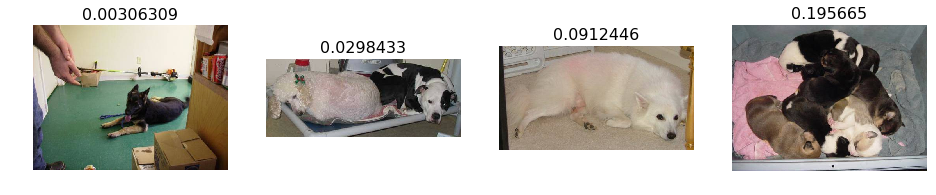

In [51]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


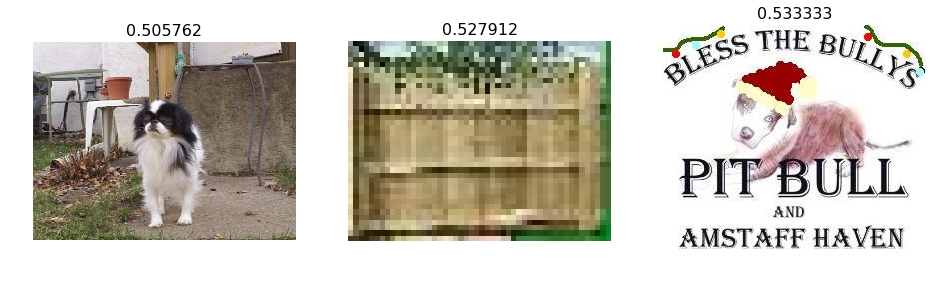

In [52]:
most_uncertain = np.argsort(np.abs(probs -0.5))[1:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The method `learn.lr_find()` helps you find an optimal learning. It uses the technique dveloepd in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a *new* learner, since we want to know how to set the learning rate for a new (untrained) model.

In [54]:
learn = ConvLearner.pretrained(ARCH, data, precompute=True)

In [55]:
lrf = learn.lr_find()

A Jupyter Widget

 79%|███████▉  | 284/360 [00:01<00:00, 167.04it/s, loss=0.432] 


Above, it stopped at 79% because the loss had clearly begun to get worse, so the finder stopped increasing the LR.

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

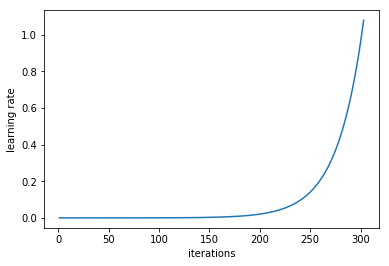

In [56]:
learn.sched.plot_lr()

The LR Finder has gone through the entire dataset, a mini-batch at a time, gradually increasing the learning rate at each mini-batch.

Note that in the previous plot *iteration* is one iteration (or minibatch) of SGD. In one epoch there are (`num_train_samples / num_iterations`) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

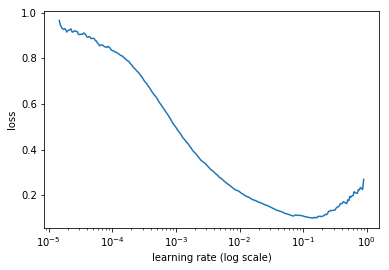

In [57]:
learn.sched.plot()

The loss is still clearly imporoving at `lr=1e-2` (0.01), so that's what we use.**NOTE** that the optimal learning rate can chance as we're training the model, so you may want to re-run this function from time to time. -- Cool makes me think of an automated pipeline.

We want to pick the largest learning rate where the loss is clearly improving.

**WHAT YOU DO:** Call `learn.lr_find()` and then you call `learn.sched.plot()` on the learning rate scheduler, find the point at which the loss is still clearly going down, and pick that.

## Improving our model

### Data Augmentation

If you try training for more epochs, you'll notice that we start to *overfit*, meaning our model is learning to recognize the specific images in the training set, rather than generalizing such that we also get good results on the validation set. One way to fix this is to effectively create more data, via *data augmentation*. This refers to randomly changing the images in ways that shouldn't impact their interpretation, such as horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (augmentation transforms) to `tfms_from_model`, with a list of functions to appply that randomly change the image however we wish. For photos that are largely taken from teh side (eg: most photos of dogs & cats, as opposed to top-down photos like satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

Data Augmentation is one of the most important things you can do to make a better model.

In [6]:
# aug_tfms: what kind of data augmentation do you want to do
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [7]:
# function to visualize data augmentation
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
# this just re-initializes the data object w/ data augmentation specified,
# dat aug is done randomly, so a different kind is displayed each time

In [65]:
ims = np.stack([get_augs() for i in range(6)])

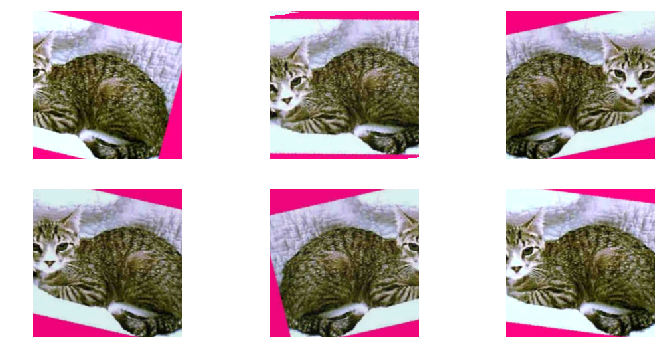

In [67]:
plots(ims, rows=2)

Let's createa a new `data` object that includes this augmentation in the transforms.

`precompute=True` is saving all up to the penultimate layer activations. We can *very* quickly train a linear model atop those. But Data Augmentation won't work since activations are precomputed.

In [5]:
ARCH = resnet34

In [12]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=16)
learn = ConvLearner.pretrained(ARCH, data, precompute=True)

In [69]:
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.       0.05361  0.02727  0.98926]                          



We can set `learn.precompute=False` and then run a few more epochs to use Data Augmentation.

In [13]:
learn.precompute = False

By default, when we create a learner, it sets all by the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [71]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.04552  0.02614  0.98926]                         
[ 1.       0.04318  0.02857  0.98877]                         
[ 2.       0.04194  0.02712  0.98926]                         



Above: the accuracy isn't really improving, but we're not overfitting because the training loss is worse than the validation loss. Generally: if your training loss is much better than your validation loss: your model's not generalizing.

`cycle_len=..` enables SGDR:

We're using a technique called *Stochastic Gradient Descent with Restarts (SGDR)*, a variant of *Learning Rate Annealing* - which graudally deceases the learning rate as training progresses. This is helpful bc as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a fragile part of the weight space -- where small changes to the weights may result in large changes to the loss. To encourage our model to find parts of the weight space that are both accurate and stable, we increase the learning rate from time to time (restarts), to force it to jump to a different part of the weight space if the current area is "spikey".

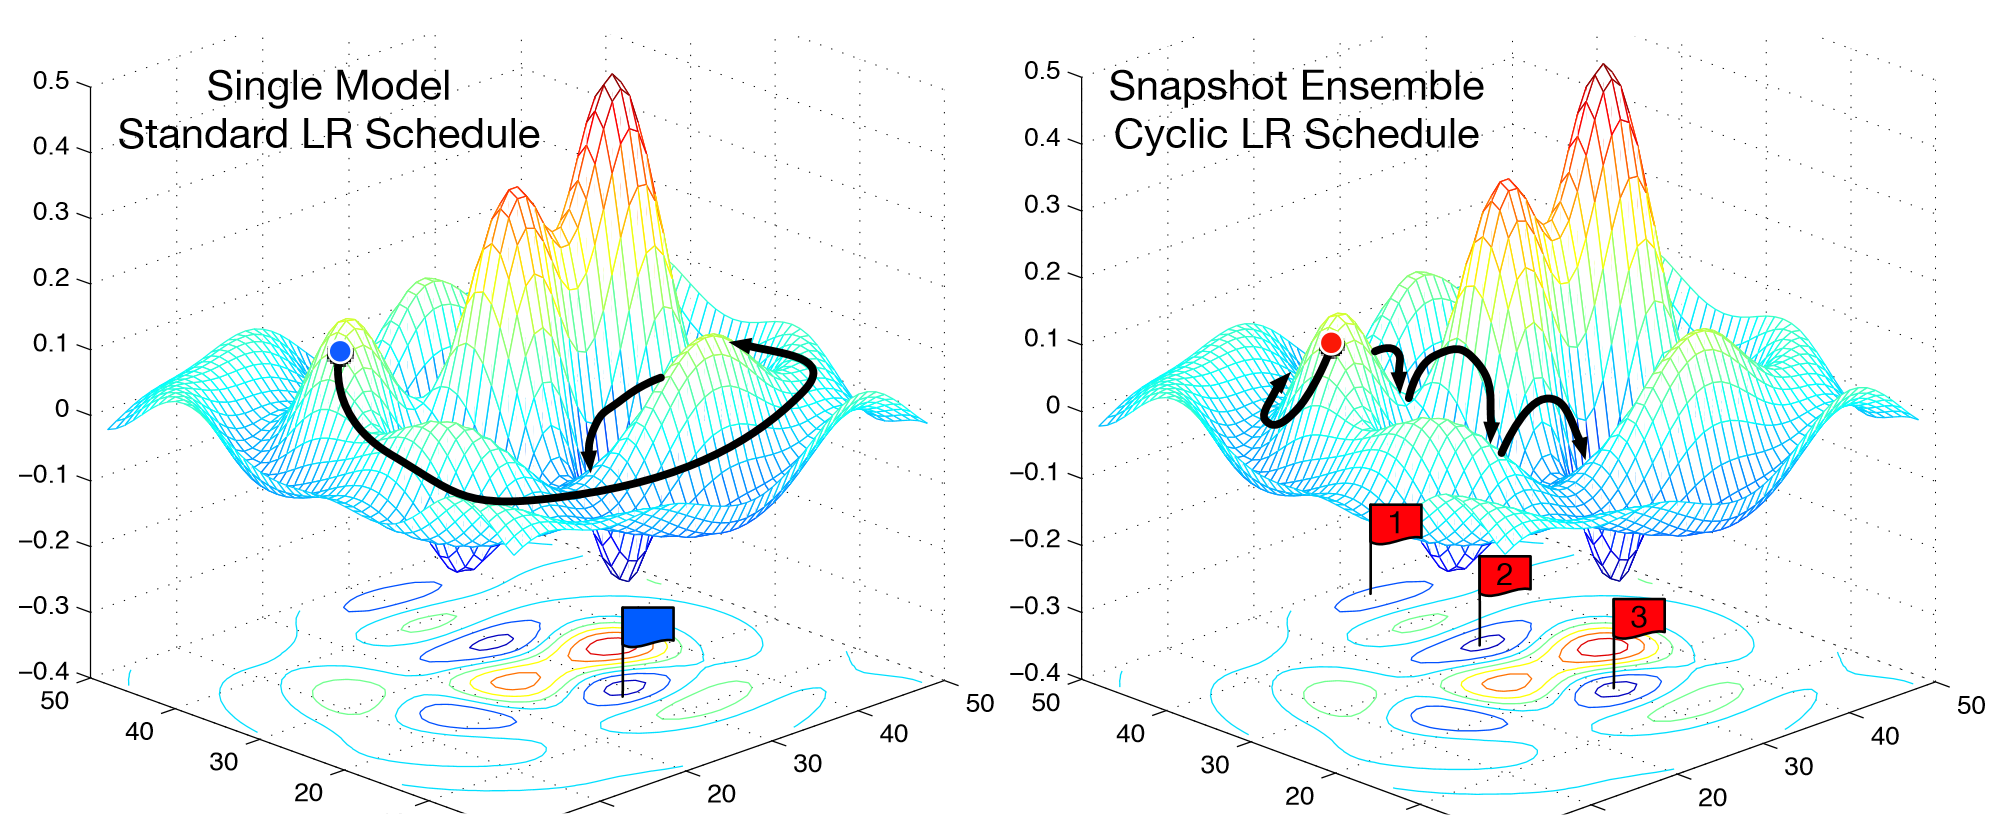
(From paper: [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)

The `cycle_len` parameter is the number of epochs between resetting the learning rate, and the number of times this happesn is the *number of cycles*, and is what we're actually passing as the 2nd paramter to `fit()`. So here's what our actual learning rate looks like:

Instead of a hacky manual decrease by an order of magnitude (common in academia & industry) method to LR annealing; it's better to choose a functional form. A great one turns out to be half a Cosine curve. (~ backwards 'lazy' S). That's: Cosine Annealing.

To do Snapshot Ensembling where the min-LR weights are saved & averaged, specify `cycle save name` along with `cycle_len`.

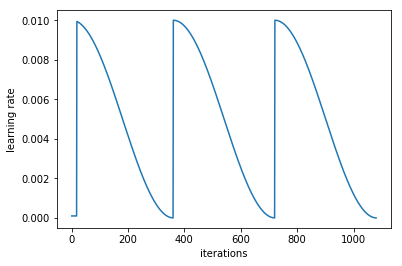

In [72]:
learn.sched.plot_lr()

Above we're doing Cosine Annealing, then jumping back up, then repeat. So we wan't our LR to be aggressive enough to break out of unstable zones. The changing of the LR every minibatch turns out to be critical, and is not something done yet in academia/industry.

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training from scratch.

In [73]:
learn.save('224_lastlayer')

In [14]:
learn.load('224_lastlayer')

### Fine-tuning and Differential Learning Rate Annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call `unfreeze()`.

This is how we setup to change the convolutional filters themselves. `.unfreeze()` unfreezes all layers.

In [15]:
learn.unfreeze()

**NOTE** that the other layers have *already* been trained to recognize ImageNet photos (whereas our final layers were randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we'd expect them to need less fine-tuning for new datasets. For this reason we'll use Differential Learning Rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this technique in the literature that we're aware of.

This array of LRs lets us tune the amount of learning/change to each layer/set of layers.

> This ability to unfreeze and then use differential learning rates is, I've found, the secret taking a pretty good model and turning it into an awesome model
-- [J.Howard](https://youtu.be/JNxcznsrRb8?t=2886)

This will assign the LRs to groups of layers.

you can do `learn.unfreeze_to(.)` and pass in a layer number, as well -- this is rarely needed thanks to the power of Dftnl LRS. This unfreezes all layers from the index onwards.

In [16]:
lr = np.array([1e-4, 1e-3, 1e-2])

# THIS MURDERED MY GFX MEMORY. STOPPING HERE, CONTINUE ÜYREN.

oh yeah, little note: the more layers you unfreeze the more memory (and compute?) intensive training becomes.

If `cycle_len=2` and `n_cycles=3`, then the learner would train 3 cycles each of 2 epochs. But the below will train 7 epochs, not 6, because of `cycle_mult=2`, which multiplies the number of iterations by a factor (scaling the LR-Annealing linearly w/ time). This serves to get the learner to jump out of spikey loss spaces quickly at first, and once it's begun to find a good space, do more and more exploring as time goes on.

> In practice I find this: `3` cycles, startng at `1`, `cycle_mult=2` works v.very often to get a pretty decent model. If not I'll do `3` cycles of length `2` with no `cycle_mult`. -- [J.Howard](https://youtu.be/JNxcznsrRb8?t=3281)

In [17]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.07429  0.02843  0.9905 ]                           
[ 1.       0.06685  0.02455  0.9895 ]                           
[ 2.       0.04321  0.02216  0.99   ]                           
[ 3.       0.04953  0.03022  0.9895 ]                           
[ 4.       0.02759  0.0255   0.9915 ]                           
[ 5.       0.03608  0.0242   0.9925 ]                           
[ 6.       0.02885  0.025    0.9915 ]                            



Another trick is adding the `cycle_mult` parameter.

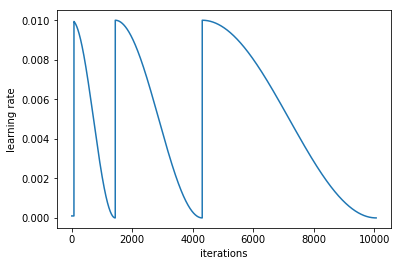

In [18]:
learn.sched.plot_lr()

Note that what's being plotted above is the learning rate of the *final* layers. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (ie: the first layers have 100x smaller, and middle layers 10x smaller LRs, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [19]:
learn.save('224_all')

In [ ]:
learn.load('224_all')

There's something else we can do with Data Augmentation: use it at *inference* time (aka *test* time). This is *Test Time Augmentation*, TTA.

TTA makes predictions on the images in your validation set and on a number of randomly augmented versions of them (by default: original image + 4 augmented vsns). It then takes the average prediction from them and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [20]:
# this is running TTA on the validation data
log_preds, y = learn.TTA()
accuracy(log_preds, y)

0.99350000000000005

This dataset generally gets a 10-20% reduction in error when using TTA at this point.

## 8. Analyzing Results

### Confusion Matrix

In [21]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

A common way to analyze the result of a classification model is to use a [Confusion Matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we cna use for this:

In [23]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print the matrix, or show a graphica view (mainly used for dependents w/ a large num of categories)

[[992   8]
 [  5 995]]


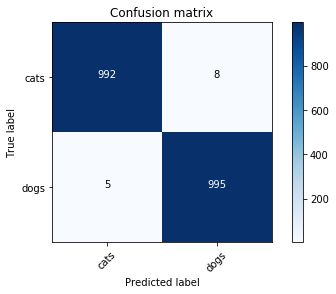

In [24]:
plot_confusion_matrix(cm, data.classes)

### Looking at Pictures Again

Most incorrect cats


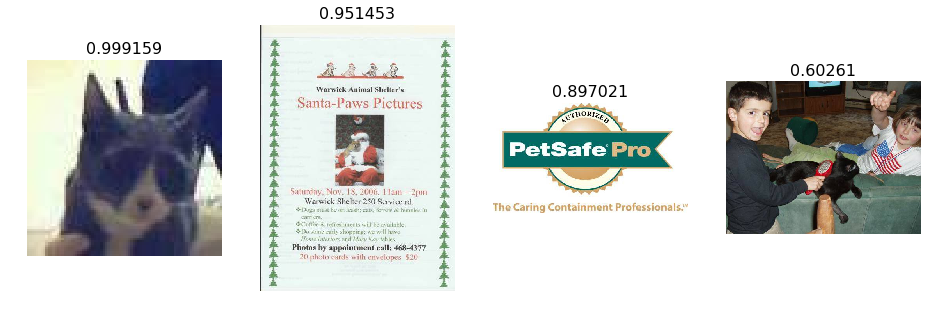

In [28]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


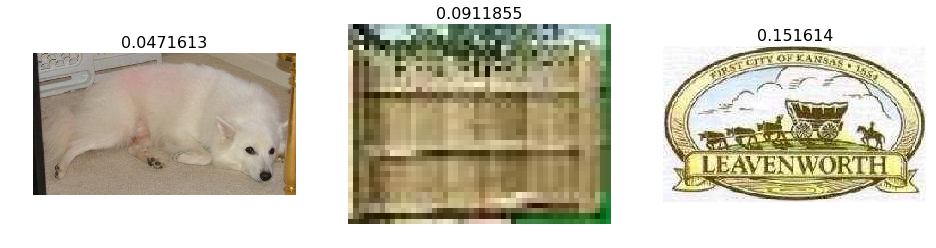

In [31]:
plot_val_with_title(most_by_correct(1, False)[1:], "Most incorrect dogs")

## 9. Review: easy steps to train a World-Class Image Classifier

1. Enable data augmentation, and `precompute=True`
2. Use `lr_find()` to find the highest leanring rate where loss is stil clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (ie `precompute=False`) for 2-3 epochs w/ `cycle_len=1`
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use `lr_find()` again
8. Train full network with `cycle_mult=2` until over-fitting


**NOTE** if you call `lr_find()` having set differential LRs, it'll print out the LR of the last layer group.

## 10. Understaind the Code for our First Model

Looking at the Dogs v Cats code line by line.

**tfms** stands for *transformations*. `tfms_from_model` takes care of resizing, image cropping, initial normalization (creating data w/ (mean, stdev) of (0,1)), and more.

In [ ]:
tfms = tfms_from_model(resnet34, sz)

We need a **path** that points to the dataset. In this path we'll also store temprorary data and final results. `ImageClassifierData.from_paths` reads data from a provided path and creates a dataset ready for training.

In [ ]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

`ConvLearner.pretrained` builds a *learner* that contains a pre-trained model. The last layer of the model needs to be replaced w/ the layer of the right dimensions. The pretrained model was trained for 1000 classes, therefore the final layer predicts a vector of 1000 probabilities. The model for cats and dogs needs to output a 2D vector. The diagram below shows an example of how this was done in one of the earliest successful CNNs. The layer "FC8" here would be replaced w/ a new layer w/ 2 outputs.

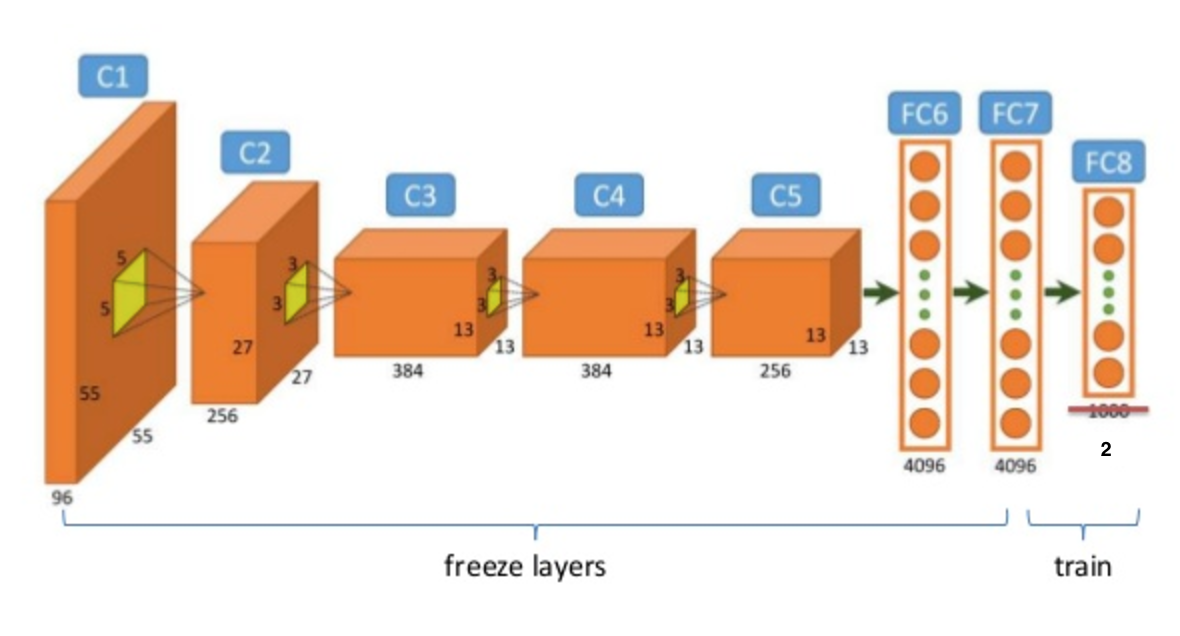

[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

In [ ]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

*Parameters* are learned by fitting a model to the data. *Hyperparameters* are another kind of parameter, that can't be directly learned from the regular training process. These parameters express 'higher-level' propoerties of the mdoel such as its complexity or how fast it should learn. Two examples of hyperpars are the *learning rate* and the *number of epochs*.

During the iterative training of a neural network, a *batch* or *mini-batch* is a subset of training samples used in one iterations of SGD. An *epoch* is a single pass thru the entire training set which consists of multiple iters of SGD

We can now *fit* the model - that is, use *Gradient Descent* to find the best pars for the fully connected layer we added, that can separate cat pictures from dog pictures. We need to pass 2 hyperpars: the *learning rate* (generally 1e-2, or 1e-3 is a good startin gpoint) and the *number of epochs* (you can pass in a higher number and just stop training when you see it's no longer improving, then re-run it with the number of epochs you found works well).

In [ ]:
learn.fit(1e-2, 1)

## Analyzing results: Loss and Accuracy

When we run `learn.fit` we print 3 performance vals (above). The 1st is **loss** in the training set, the 2nd is loss in the validation set, and the 3rd is validaiton accuracy.

**Accuracy** is the ratio of correct predictions to the total number of predictions.

In Machine Learning, the **loss** function or cost function represents the price paid for inaccuracy of predictions.

The loss associated with one example in binary classification is given by: `-(y * log(p) + (1-y) * log(1-p))` where `y` is the true label of `x` and `p` is the probability predicted by our model that the label is `1`.

In [ ]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [ ]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

**NOTE** that in our toy exmaple above our accuracy is 100% and our loss is 0.16. Compare that to a loss of 0.03 that we're getting while predicting cats and dogs. Exercise: play w/ `preds` to get a lower loss for this example.

**Example:** Here's an example on how to compute the loss for 1 exmpl of a binary clsfn problem. Suppose for an image `x` w/ label `1`, your model gives it a prediction of `0.9`. For this case the loss should be small bc our model is predicting a lebel `1` w/ high probability.

`loss = -log(0.9) = 0.10`

Now suppose `x` has a label `0` but our model is predicted `0.9`, in this case our lossshould be much larger:

`loss = -log(1-0.9) = 2.30`

* Exc: look at the other cases and convince yourself that this makes sense.
* Exc: how would you rewrite `binary_loss` using `if` instead of `*` and `+`?

Why not just maximuze accuracy? The binary classification loss is an easier function to optimize.